# Demo: Transcriptional Patterns in CD4 T Cells

This demo uses public data from 10x Genomics

_5k Peripheral blood mononuclear cells (PBMCs) from a healthy donor with cell surface proteins (Next GEM)_

  - as processed by Cell Ranger 3.1.0
  - [Dataset Link](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.1.0/5k_pbmc_protein_v3_nextgem)

For this demo, you need the filtered h5 file, "Feature / cell matrix HDF5 (filtered)", with the filename:

- `5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5`

## Covered Here

- Data preprocessing and filtering
- Computing Autocorrelation in Hotspot to identify lineage-related genes
- Computing local correlations between lineage genes to identify heritable modules
- Plotting modules, correlations, and module scores

In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "master"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/hotspot@$branch#egg=hotspot
    !pip install --quiet scanpy
    !pip install --quiet muon
    !pip install mplscience

     |████████████████████████████████| 72 kB 843 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.10 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.
     |████████████████████████████████| 91 kB 4.3 MB/s 
     |████████████████████████████████| 2.0 MB 8.9 MB/s 
     |████████████████████████████████| 86 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 29.4 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 287 kB 7.6 MB/s 
     |████████████████████████████████| 41 kB 115 kB/s 
     |████████████████████████████████| 48 kB 4.3 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.0
    Uninstalling importlib-metadata-4.11.0:
      Successfully uninstalled importlib-metadata-4.11.0
ERROR: pi

In [2]:
# download the data
if IN_COLAB:
    !wget https://cf.10xgenomics.com/samples/cell-exp/3.1.0/5k_pbmc_protein_v3_nextgem/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5

--2022-02-18 18:00:14--  https://cf.10xgenomics.com/samples/cell-exp/3.1.0/5k_pbmc_protein_v3_nextgem/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18083112 (17M) [binary/octet-stream]
Saving to: ‘5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5’

5k_pbmc_protein_v3_ 100%[===================>]  17.25M  44.4MB/s    in 0.4s    

2022-02-18 18:00:14 (44.4 MB/s) - ‘5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5’ saved [18083112/18083112]



In [3]:
import warnings; warnings.simplefilter('ignore')

import hotspot
import scanpy as sc
import muon as mu

import numpy as np
import mplscience

## Load data from h5 file and extract CD4 T cells

In [4]:
mdata = mu.read_10x_h5("/content/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
mdata.var_names_make_unique()

In [6]:
mdata

MuData object with n_obs × n_vars = 5527 × 33570
  var:	'feature_types', 'gene_ids', 'genome'
  2 modalities
    rna:	5527 x 33538
      var:	'gene_ids', 'feature_types', 'genome'
    prot:	5527 x 32
      var:	'gene_ids', 'feature_types', 'genome'

In [7]:
adata = mdata.mod["rna"]

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


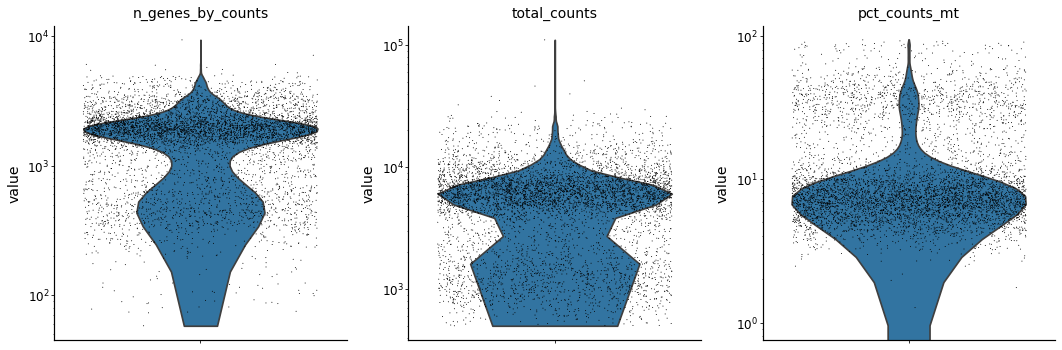

In [9]:
with mplscience.style_context():
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                jitter=0.4, multi_panel=True, log=True)

### Extract the CD4 T Cells based on surface protein abundance

In [10]:
from muon import prot as pt
pt.pp.clr(mdata['prot'])

prot_data = mdata.mod["prot"]

... storing 'feature_types' as categorical
... storing 'genome' as categorical


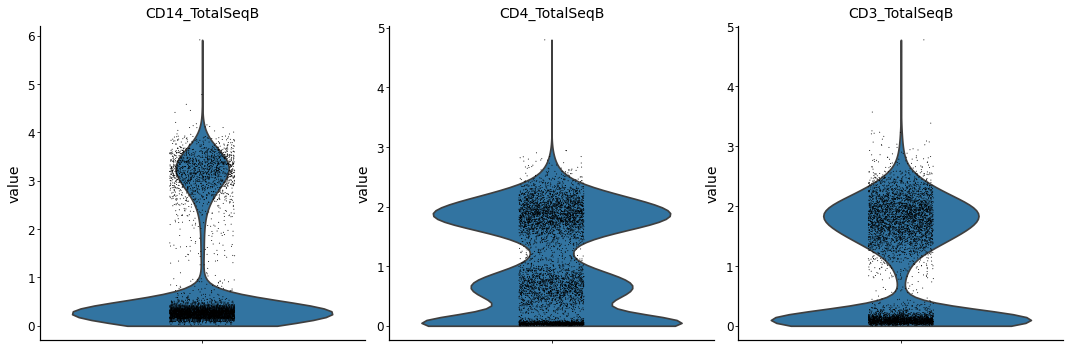

In [11]:
with mplscience.style_context():
    sc.pl.violin(prot_data, keys=["CD14_TotalSeqB", "CD4_TotalSeqB", "CD3_TotalSeqB"], multi_panel=True)

In [12]:
# now create a CD4 T cell mask
is_cd4 = np.asarray(
    (prot_data[:, 'CD14_TotalSeqB'].X.A < 2) &
    (prot_data[:, 'CD4_TotalSeqB'].X.A > 1) &
    (prot_data[:, 'CD3_TotalSeqB'].X.A > 1)
).ravel()

adata_cd4 = adata[is_cd4]
sc.pp.filter_cells(adata_cd4, min_genes=1000)
sc.pp.filter_genes(adata_cd4, min_cells=10)
adata_cd4 = adata_cd4[adata_cd4.obs.pct_counts_mt < 16].copy()

adata_cd4

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 1547 × 12456
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

### Compute a Latent Space with PCA


In the Hotspot manuscript, we used [scVI](https://github.com/yoseflab/scvi) for this which has improved performance over PCA.  However, to make this notebook easier to run (with less added extra dependencies), we'll just run PCA using scanpy.

In [13]:
adata_cd4.layers["counts"] = adata_cd4.X.copy()
sc.pp.normalize_total(adata_cd4)
sc.pp.log1p(adata_cd4)
adata_cd4.layers["log_normalized"] = adata_cd4.X.copy()
sc.pp.scale(adata_cd4)
sc.tl.pca(adata_cd4)

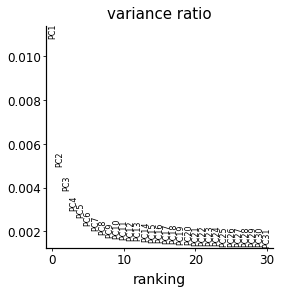

In [14]:
with mplscience.style_context():
    sc.pl.pca_variance_ratio(adata_cd4)

In [15]:
# rerun with fewer components
sc.tl.pca(adata_cd4, n_comps=10)

## Creating the Hotspot object

To start an analysis, first create the hotspot object
When creating the object, you need to specify:

- The gene counts matrix
- Which background model to use
- The latent space we are using to compute our cell metric
    - Here we use the reduced, PCA results
- The per-cell scaling factor
    - Here we use the number of umi per barcode
    
In the Hotspot publication, we use the raw counts and the negative binomial ('danb') model. We repeat that choice here.
    
Once the object is created, the neighborhood is then computed with `create_knn_graph`

The two options that are specificied are `n_neighbors` which determines the size of the neighborhood, and `weighted_graph`.

Here we set `weighted_graph=False` to just use binary, 0-1 weights (only binary weights are supported when using a lineage tree) and `n_neighbors=30` to create a local neighborhood size of the nearest 30 cells.  Larger neighborhood sizes can result in more robust detection of correlations and autocorrelations at a cost of missing more fine-grained, smaller-scale patterns.

In [16]:
# Create the Hotspot object and the neighborhood graph
# hotspot works a lot faster with a csc matrix!
adata_cd4.layers["counts_csc"] = adata_cd4.layers["counts"].tocsc()
hs = hotspot.Hotspot(
    adata_cd4, 
    layer_key="counts_csc", 
    model='danb', 
    latent_obsm_key="X_pca",
    umi_counts_obs_key="total_counts"
)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

## Determining informative genes

Now we compute autocorrelations for each gene, in the pca-space, to determine which genes have the most informative variation.

In [17]:
hs_results = hs.compute_autocorrelations(jobs=4)

hs_results.head(15)

100%|██████████| 12456/12456 [00:09<00:00, 1313.64it/s]


,C,Z,Pval,FDR
Gene,,,,
GZMH,0.664524,141.517601,0.0,0.0
B2M,0.637732,126.077766,0.0,0.0
RPS3A,0.679940,119.654615,0.0,0.0
CCL5,0.602698,118.413519,0.0,0.0
GZMA,0.613364,106.382416,0.0,0.0
NKG7,0.770962,106.305566,0.0,0.0
RPS13,0.583559,103.431142,0.0,0.0
RPL32,0.643652,99.413033,0.0,0.0
GZMK,0.438507,95.198094,0.0,0.0


## Grouping genes into lineage-based modules

To get a better idea of what expression patterns exist, it is helpful to group the genes into modules.

Hotspot does this using the concept of "local correlations" - that is, <br> 
correlations that are computed between genes between cells in the same neighborhood.

Here we avoid running the calculation for all Genes x Genes pairs and instead <br> only run this on genes that have significant autocorrelation to begin with.

The method `compute_local_correlations` returns a Genes x Genes matrix of <br>
Z-scores for the significance of the correlation between genes.  This object <br>
is also retained in the `hs` object and is used in the subsequent steps.

In [18]:
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(500).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=4)


Computing pair-wise local correlation on 500 features...


100%|██████████| 124750/124750 [00:26<00:00, 4788.62it/s]


Now that pair-wise local correlations are calculated, we can group genes into modules.

To do this, a convenience method is included `create_modules` which performs <br> 
agglomerative clustering with two caveats:

- If the FDR-adjusted p-value of the correlation between two branches exceeds `fdr_threshold`, <br>
then the branches are not merged.
- If two branches are two be merged and they are both have at least `min_gene_threshold` genes, <br>
then the branches are not merged.  Further genes that would join to the resulting merged module <br> (and are therefore ambiguous) either remain unassigned (if `core_only=True`) or are assigned to the module with the <br>
smaller average correlations between genes, i.e. the least-dense module (if `core_only=False`)

The output is a Series that maps gene to module number.  Unassigned genes are indicated with a module number of `-1`

This method was used to preserved substructure (nested modules) while still giving the analyst <br>
some control. However, since there are a lot of ways to do hierarchical clustering, you can also <br>
manually cluster using the gene-distances in `hs.local_correlation_z`

In [19]:
modules = hs.create_modules(
    min_gene_threshold=15, core_only=True, fdr_threshold=0.05
)

modules.value_counts()

 1     89
-1     74
 5     42
 10    35
 8     34
 3     32
 6     32
 2     30
 12    30
 11    28
 9     23
 4     18
 7     18
 13    15
Name: Module, dtype: int64

## Plotting module correlations

A convenience method is supplied to plot the results of `hs.create_modules`

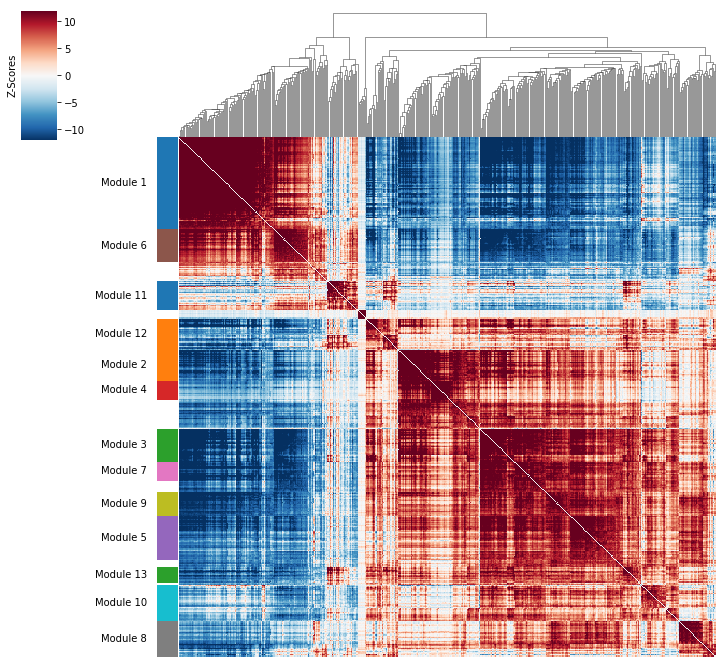

In [20]:
hs.plot_local_correlations(vmin=-12, vmax=12)

To explore individual genes, we can look at the genes with the top *autocorrelation* <br>
in a given module as these are likely the most informative.

In [21]:
# Show the top genes for a module

module = 9

results = hs.results.join(hs.modules)
results = results.loc[results.Module == module]

results.sort_values('Z', ascending=False).head(10)

,C,Z,Pval,FDR,Module
Gene,,,,,
MIAT,0.177204,33.820983,4.847800e-251,3.531240e-249,9.0
GBP5,0.208299,32.325981,1.509384e-229,1.005395e-227,9.0
AC004687.1,0.188952,31.505214,3.684686e-218,2.378054e-216,9.0
MAF,0.187160,28.825567,5.129598e-183,2.985714e-181,9.0
NEAT1,0.232268,27.821226,1.200974e-170,6.738436e-169,9.0
PPP2R5C,0.143905,26.519352,2.899214e-155,1.517336e-153,9.0
PYHIN1,0.165599,26.442412,2.230444e-154,1.162444e-152,9.0
OPTN,0.157458,24.916422,2.469573e-137,1.206314e-135,9.0
TNFRSF1B,0.235988,24.834521,1.900423e-136,9.210766e-135,9.0


## Summary Module Scores

To aid in the recognition of the general behavior of a module, Hotspot can compute <br>
aggregate module scores.

In [22]:
module_scores = hs.calculate_module_scores()

module_scores.head()

Computing scores for 13 modules...


100%|██████████| 13/13 [00:00<00:00, 15.00it/s]


,1,2,3,4,5,6,7,8,9,10,11,12,13
AAACGAATCATGAGAA-1,3.608087,-1.332635,-2.765422,-0.375033,-1.989659,2.508126,-1.359988,-0.366706,-1.243118,-1.344597,-1.256328,-1.276302,-1.621497
AAACGCTAGGATAATC-1,5.611630,-1.164912,-2.213463,-0.401776,-1.021839,1.402271,-1.262448,-0.809071,-1.175233,-1.255394,-1.539582,-1.744215,-1.434432
AAAGAACTCTTGGTCC-1,-11.978400,-0.568684,4.818443,-0.418272,10.817546,-2.620614,4.777415,9.616011,5.739911,1.219397,-3.064364,-0.916039,0.462314
AAAGGATAGCCGGATA-1,6.380645,-1.209119,-2.518803,-0.393690,-1.559012,2.280116,-1.609583,-0.948184,-1.546197,-1.430628,0.211499,-1.771080,-0.803406
AAAGGATTCCGAGTGC-1,4.914818,-0.754171,0.405689,-0.369875,-0.676271,-1.565022,0.578168,-0.535698,-0.047888,2.093285,-3.645493,-0.315027,-1.429217


Here we can visualize these module scores by plotting them over a UMAP of the cells

First we'll compute the UMAP

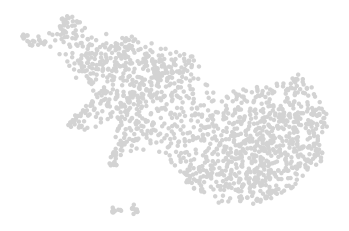

In [23]:
sc.pp.neighbors(adata_cd4)
sc.tl.umap(adata_cd4)
sc.pl.umap(adata_cd4, frameon=False)

In [24]:
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    adata_cd4.obs[key] = module_scores[c]
    module_cols.append(key)

Finally, we plot the module scores on top of the UMAP for comparison

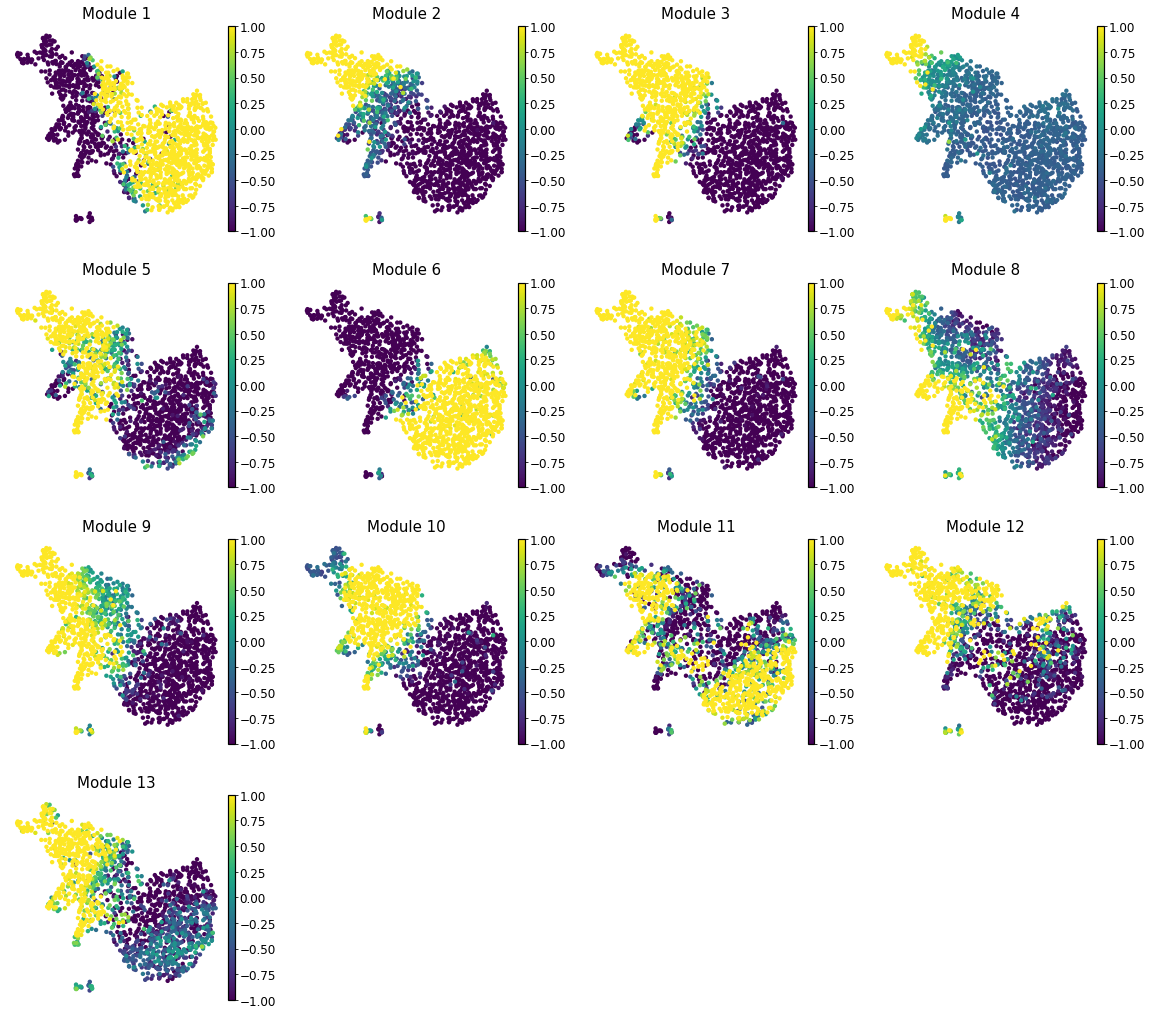

In [25]:
with mplscience.style_context():
    sc.pl.umap(adata_cd4, color=module_cols, frameon=False, vmin=-1, vmax=1)